In [1]:
# Import of packages
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [2]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

**The data you have access to is:**

In [3]:
np.random.seed(2020)
x1,x2,y = DGP(10000)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}$$

In [4]:
#Creating the matrix X
a = [1]*10000
X = np.matrix(np.vstack((a,x1,x2)))
print('stacked:\n',X)

stacked:
 [[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [-1.76884571  0.07555227 -1.1306297  ...  0.0370484   1.70892684
   2.06128052]
 [-0.18279442  0.78062368 -1.01220533 ... -1.44286811 -0.10668645
   0.55908184]]


In [5]:
#Transposing and inversing the matrix X according to the beta_hat given
x = X.transpose()
X_mul=X @ x
X_mul_inv=np.linalg.inv(X_mul)
x_mul=X_mul_inv@X
y1=y[:,np.newaxis]

In [6]:
# Estimating the vector of coefficients using OLS 
beta=x_mul@y1
beta0_hat=float(beta[0])
beta1_hat=float(beta[1])
beta2_hat=float(beta[2])
print(f'beta0_hat = {beta0_hat:.3f}, beta1_hat = {beta1_hat:.3f}, beta2_hat = {beta2_hat:.3f}') 

beta0_hat = 0.096, beta1_hat = 0.293, beta2_hat = 0.503


**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

In [7]:
#Predicting the model given the values obtained in Q1 
beta0_predict=[beta0_hat]*10000
x1_predict=beta1_hat*x1
x2_predict=beta2_hat*x2
y_predict = beta0_predict + x1_predict + x2_predict

Creating 3D Plot

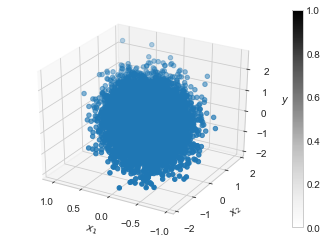

In [8]:
# a. main
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.scatter(x1_predict,x2_predict, y_predict);        

# b. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')

# c. invert xaxis
ax.invert_xaxis()

# d. colorbar
fig.colorbar(cs);

**Question 3:** Esimtate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

In [9]:
#Initially defining the residuals
u=np.empty(len(x1))
def residuals(beta0,beta1,beta2):
    for i in range(len(x1)):
        u[i] = (y1[i] - beta0 - beta1*x1[i] - beta2*x2[i])
    return u

In [10]:
#Defining objective function
def OLS_objective_function(x,beta0,beta1,beta2):
    beta0=x[0]
    beta1=x[1]
    beta2=x[2]
    OLS_sum_squared_errors = np.sum(residuals(beta0,beta1,beta2)**2)
    return OLS_sum_squared_errors

    #Initial guess of betas
    beta_guess= np.array([1,1,1]) 

    #Calling a solver
    res = optimize.minimize(OLS_objective_function,beta_guess,method='Nelder-Mead',args=(beta0,beta1,beta2))

#Printing the results
print(f'beta0 = {res.x[0]:.3f}, beta1 = {res.x[1]:.3f}, beta2 = {res.x[2]:.3f}') 

NameError: name 'res' is not defined

** Comparing the results from the numerical solver with that of the matrix algebra **

The comparison reveals that we down to the fourth decimal obtain the exact same result.

**Question 4:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

In [11]:
#Defining a new objective function
def LAD_objective_function(x,beta0,beta1,beta2):
    beta0=x[0]
    beta1=x[1]
    beta2=x[2]
    LAD_sum_squared_errors = np.sum(np.absolute(residuals(beta0,beta1,beta2)))
    return LAD_sum_squared_errors    

    res = optimize.minimize(LAD_objective_function,beta_guess,method='Nelder-Mead',args=(beta0,beta1,beta2))

print(f'beta0 = {res.x[0]:.3f}, beta1 = {res.x[1]:.3f}, beta2 = {res.x[2]:.3f}')

NameError: name 'res' is not defined

**Question 5:** Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

** OLS Method **

Repeating the estimation using the OLS method 5000 times, drawing a new random sample from the data generating process each time.

In [12]:
#Setting K=5000
beta0_OLS = np.empty(5000)
beta1_OLS = np.empty(5000)
beta2_OLS = np.empty(5000)

#Setting N=50 and K=5000
for i in range(5000):
    x1_Q5,x2_Q5,y_Q5 = DGP(50)
    
    #Defining new residuals
    u_Q5=np.empty(len(x1_Q5))
    def residuals_Q5(beta0_OLS,beta1_OLS,beta2_OLS):
        for i in range(len(x1_Q5)):
            u_Q5[i] = (y_Q5[i] - beta0_OLS - beta1_OLS*x1_Q5[i] - beta2_OLS*x2_Q5[i])
        return u_Q5
    
    #Defining new objective function
    def objective_function_Q5_OLS(x,beta0_OLS,beta1_OLS,beta2_OLS):
        beta0_OLS=x[0]
        beta1_OLS=x[1]
        beta2_OLS=x[2]
        sum_squared_errors_Q5_OLS = np.sum(residuals_Q5(beta0_OLS,beta1_OLS,beta2_OLS)**2)
        return sum_squared_errors_Q5_OLS

    #Initial guess of betas
    beta_guess= np.array([1,1,1]) 

    #Calling a solver 
    res = optimize.minimize(objective_function_Q5_OLS,beta_guess,method='Nelder-Mead',args=(beta0_OLS,beta1_OLS,beta2_OLS))
    beta0_OLS[i-1]=res.x[0]
    beta1_OLS[i-1]=res.x[1]
    beta2_OLS[i-1]=res.x[2]

#Printing the results
print(res.x[0])
print(res.x[1])
print(res.x[2])

-0.36741947374319195
0.3832086503631519
0.5383944498743871


** LAD Method **

Repeating the estimation using the LAD method 5000 times, drawing a new random sample from the data generating process each time

In [13]:
#Setting K=5000
beta0_LAD = np.empty(5000)
beta1_LAD = np.empty(5000)
beta2_LAD = np.empty(5000)

#Setting N=50 and K=5000
for i in range(5000):
    x1_new,x2_new,y_new = DGP(50)
    
    #Defining new residuals
    u_Q5=np.empty(len(x1_Q5))
    def residuals_Q5(beta0_LAD,beta1_LAD,beta2_LAD):
        for i in range(len(x1_Q5)):
            u_Q5[i] = (y_Q5[i] - beta0_LAD - beta1_LAD*x1_Q5[i] - beta2_LAD*x2_Q5[i])
        return u_Q5
   
    #Defining new objective function
    def objective_function_Q5(x,beta0_LAD,beta1_LAD,beta2_LAD):
        beta0_LAD=x[0]
        beta1_LAD=x[1]
        beta2_LAD=x[2]
        sum_squared_errors_Q5_LAD = np.sum(np.abs(residuals_Q5(beta0_LAD,beta1_LAD,beta2_LAD)))
        return sum_squared_errors_Q5_LAD

    #Calling a solver 
    res = optimize.minimize(objective_function_Q5,beta_guess,method='Nelder-Mead',args=(beta0_LAD,beta1_LAD,beta2_LAD))
    beta0_LAD[i-1]=res.x[0]
    beta1_LAD[i-1]=res.x[1]
    beta2_LAD[i-1]=res.x[2]

#Printing the results
print(res.x[0])
print(res.x[1])
print(res.x[2])

-0.11102688972112162
0.27255789455102286
0.4732899704720854


** Comparing the estimates from the OLS and LAD methods using histograms **

** Histogram for $\beta_0$ **

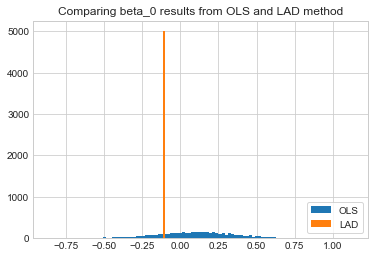

In [14]:
fig0 = plt.figure()
ax = fig0.add_subplot(1,1,1)

ax.hist(beta0_OLS,bins=100,label='OLS')
ax.hist(beta0_LAD,bins=100,label='LAD')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_title('Comparing beta_0 results from OLS and LAD method');

** Histogram for $\beta_1$ **

In [15]:
fig1 = plt.figure()
ax = fig1.add_subplot(1,1,1)

ax.hist(beta1_OLS,bins=100,label='OLS')
ax.hist(beta1_LAD,bins=100,label='LAD')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_title('Comparing beta_1 results from OLS and LAD method');

Error in callback <function flush_figures at 0x131ec3ef80> (for post_execute):


KeyboardInterrupt: 

** Histogram for $\beta_2$ **

In [ ]:
fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)

ax.hist(beta2_OLS,bins=100,label='OLS')
ax.hist(beta2_LAD,bins=100,label='LAD')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_title('Comparing beta_2 results from OLS and LAD method');

** Preferred method **

We prefer the LAD method to the OLS method, as it gives a smaller variance. This is evident from the first two graphs, as the LAD and OLS histograms have roughly the same height. That means that the there's a large amount of the data around the true paramter value, $\hat{\beta}$. However, the LAD model has a smaller variance, evident from the slimmer widths in the plots, meaning that our estimates are close to the true parameter values of the betas. This is what drives our conclusion that the LAD model is preferred. 

However, we note that in the 3rd historgram, plotting the $\beta_2$ values, the OLS histogram exhibits a significantly higher curve than the OLS. Thus, one could argue that the conclusion is more ambiguous.

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [7]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25
chi =0.9

# b. grids
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

In [3]:
def m2(r, a, y):
    if y==1-Delta:
        return (1+r)*a+(1-Delta)
    elif y==1:
        return (1+r)*a+1
    else: 
        return (1+r)*a+(1+Delta)

def ex_dur_con(m2,c):
    return m2-c

def assets1(m1,d):
    return m1-d

In [4]:
def v2(m2,c,rho,d,chi,alpha):
    return (c**alpha*(d+chi*ex_dur_con(m2,c))**(1-alpha))**(1-rho)/(1-rho)

def v1(m1, beta, Delta, r, v2_interp):
    # a. v2 value, if low income
    m2_low = (1+r)*(assets1(m1,d)) + (1-Delta)
    v2_low = v2_interp((m2_low, d_vec))[0]
    # b. v2 value, if medium income
    m2_medium = (1+r)*(assets1(m1,d)) + 1
    v2_medium = v2_interp((m2_medium,d_vec))[0]
    # c. v2 value, if high income
    m2_high = (1+r)*(assets1(m1,d))+(1+Delta)
    v2_high = v2_interp((m2_high,d_vec))[0]
    # d. expected v2 value
    v2 = (1/3)*v2_low + (1/3)*v2_medium + (1/3)*v2_high
    # e. total value
    return beta*v2

In [13]:
def solve_period_2(alpha, rho, chi, Delta):

    #a. Grids
    v2_vec=np.empty((100,100))
    c_vec=np.empty((100,100))

    #b. solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):
        for j,d in enumerate(d_vec):

            #i. Objective
            objective = lambda c: -v2(m2,c,rho,d,chi,alpha)

            #ii. Initial value (consuming half)
            x0=m2/2

            #iii. Optimizer
            result = optimize.minimize_scalar(objective,x0,method='bounded', bounds=[1e-8,m2])

            #iv. save
            v2_vec[i,j]= -result.fun
            c_vec[i,j]=result.x
    
    return m2_vec, d_vec, v2_vec, c_vec

# Solve
m2_vec, d_vec, v2_vec, c_vec = solve_period_2(alpha,rho,chi,Delta)


**  Value Function in Period 2, $v_2(m_2,d)$ ** 

Text(0.5, 1.0, 'Value Function in Period 2')

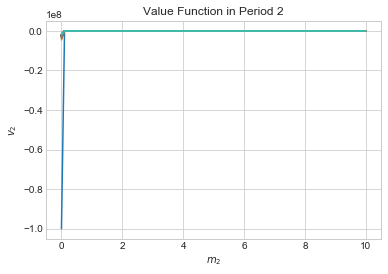

In [14]:
#Plotting the figure in 2D
fig0=plt.figure()
ax=fig0.add_subplot(1,1,1)
ax.plot(m2_vec,v2_vec)

# Adding labels to plot
ax.set_xlabel('$m_2$')
ax.set_ylabel('$v_2$')

ax.set_title('Value Function in Period 2')

When cash-on-hand is 0 in Period 2 the value function exhibits negative curvature.

** Optimal Consumption in Period 2, $c^*(m_2,d)$ ** 

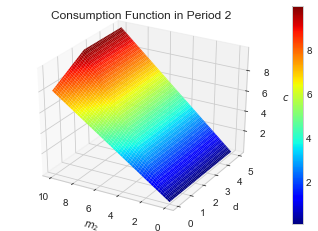

In [15]:
# Grids
m2_grid,d_grid=np.meshgrid(m2_vec,d_vec,indexing='ij')

# Plotting the figure in 3D
fig1 = plt.figure()
ax = fig1.add_subplot(1,1,1,projection='3d')
c = ax.plot_surface(m2_grid, d_grid, c_vec, cmap=cm.jet)

# Adding labels to plot
ax.set_xlabel('$m_2$')
ax.set_ylabel('d')
ax.set_zlabel('$c$')

ax.set_title('Consumption Function in Period 2')

# Inverting axis
ax.invert_xaxis()

# Adding colourbar
fig1.colorbar(c);

From the plot we see that the variable $d$, the pre-committed durable good, does not affect the consumption, while the cash-on-hand in the second period affects the consumption positively. 

** Optimal Extra Durable Consumption in Period 2, $x^*(m_2,d)$ ** 

In [17]:
# Grids
m2_grid,c_grid = np.meshgrid(m2_vec,c_vec,indexing='ij')
x_optimal = m2_grid - c_grid

# Plotting the figure in 3D
fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1,projection='3d')
x = ax.plot_surface(m2_grid,c_grid,x_optimal,cmap=cm.jet)

# Adding labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c$')
ax.set_zlabel('$x$')
ax.set_title('Extra Durable Consumption Function in Period 2')

# Inverting the xaxis
ax.invert_xaxis()

# Adding colourbar
fig2.colorbar(x);

KeyboardInterrupt: 

**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

In [ ]:
#Combining Period 1 and 2
v2_interp = interpolate.RegularGridInterpolator((m2_vec,d_vec), v2_vec,bounds_error=False,fill_value=None)

In [ ]:
# Solve
def solve_1(beta,delta,r,v2_interp):
    # a. grids
    m1_vec = np.linspace(1e-8,10,100)
    v1_vec = np.empty((100,100))
    d1_vec = np.empty((100,100))
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
            # i. objective
            obj = lambda d: -v1(m1,d,beta,delta,r,v2_interp)
            # ii. initial value (consume half)
            x0 = m1/2
            # iii. optimizer
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m1])
            # iv. save
            v1_vec[i] = -result.fun
            d1_vec[i] = result.x
    return m1_vec,v1_vec,d1_vec

# solve
m1_vec,v1_vec,d1_vec = solve_1(beta,delta,r,v2_interp)
# illustrate
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,v1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$value$')
ax.set_title('value function in period 1')
ax.set_ylim([-1.6,0]);

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [5]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

In [2]:
# Setting symbols
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
delta = sm.symbols('delta')
epsilon = sm.symbols('epsilon')
Theta = sm.symbols('Theta')
theta = sm.symbols('theta')

### The Rosenbrock Function is defined and a matrix for the Jacobian is found

In [3]:
def ros(x1,x2):
    f = (1.0-x1)**2 + 2*(x2-x1**2)**2
f = (1.0-x1)**2 + 2*(x2-x1**2)**2

jacmatrix = sm.Matrix([sm.diff(f,i) for i in [x1,x2]])

jacmatrix

Matrix([
[-8*x_1*(-x_1**2 + x_2) + 2*x_1 - 2.0],
[                   -4*x_1**2 + 4*x_2]])

### The numerical approximation of the jacobian for $f$ is computed

In [4]:
#Step 3
def rosen(x):
    return ros(x[0],x[1])

def rosenjac(x):
    return np.array([-(2.0-2*x[0])-8*x[0]*(x[1]-x[0]**2),4*(x[1]-x[0]**2)])

### Implementing the algorithm

In the following we implement the 10 steps to minimize the function $f(x)$

In [5]:
# 1. Choosing tolerance, scale factor and a small number
def gradient_descent(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=10_000):

    # 2. Guessing on x_0 and setting n=1
    x = x0
    fx = f(x0)
    n = 1

    while n < max_iter: 
        x_prev = x
        fx_prev = fx

        # 3. Computing the numerical approximation of the jacobian
        jacx = rosenjac(x)

        # 4. - 5. Defining new variables  
        fx_ast = np.inf
        theta_ast = Theta
        
        #6. Implementing stepsize 
        theta=Theta/2 

        #7. Continuing the loop
        if fx < fx_ast:
            fx_ast = fx
            theta_ast = theta

        # 8. Last step of the minimization 
        x = x_prev - theta_ast*jacx
        fx = f(x)
        if abs(fx-fx_prev) < Delta:
            break
        # 9. Implementing restriction 
        fx = f(x)
        if abs(fx<fx_prev) < epsilon:
            break
                
        # 10. Finishing loop or returning to step 3
        n += 1
        
    return x,n
    pass

**Test case:**

In [6]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'Minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('Not implemented yet')

Minimum found at (1.0005,1.0011) after 255 iterations
Not implemented yet
